# Introduction 

In the following notebook, I will creating a time series forecast aiming to predict the temperature in Spain. 

* Raw data can be found [here](https://github.com/KishenSharma6/Weather-Energy-Consumption-in-Spain/tree/master/Data/01_Raw_Data)
* Cleaned data can be found [here](https://github.com/KishenSharma6/Weather-Energy-Consumption-in-Spain/tree/master/Data/02_Cleaned_Data)
* Training and test data can be found [here](https://github.com/KishenSharma6/Weather-Energy-Consumption-in-Spain/tree/master/Data/03_Processed_Data)

**Read in libraries for notebook**

In [263]:
import numpy as np
import pandas as pd
from IPython.display import Image

import matplotlib.pyplot as plt
import warnings

**Set notebook preferences**

In [264]:
#Set preferences for pandas 
pd.set_option("display.max_rows", 101)

#Set style for visualizations
plt.style.use('Solarize_Light2')

#Font dictionary for plot titles and labels
font_title = {'fontsize' : 24, 
              'style':'italic',
              'fontweight' : 'semibold',
             'fontname':'Gill Sans MT'}

font_label = {'fontsize' : 16, 
              'style':'italic',
              'fontweight' : 'semibold',
             'fontname':'Gill Sans MT'}

#Surpress warnings
warnings.filterwarnings('ignore')

**Read in data**

In [265]:
#Set path to raw data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather/Data/03_Processed_Data'

#Read in Bilbao training and test data
train = pd.read_csv(path + '/2020_0515_temp_train.csv', parse_dates=['date_time'], index_col='date_time')
test = pd.read_csv(path + '/2020_0515_temp_test.csv', parse_dates=['date_time'], index_col='date_time')

**Data preview**

*Training data*

In [266]:
#Print data shape and preview head
print('Training data shape:',train.shape)
display(train.head())

Training data shape: (28038, 2)


,temp,temp_deseasoned1
date_time,,
2015-01-02 00:00:00,33.940636,3.126004
2015-01-02 01:00:00,33.590660,2.737800
2015-01-02 02:00:00,32.796804,2.688356
2015-01-02 03:00:00,32.554996,2.463952
2015-01-02 04:00:00,32.566640,2.374020


*Test Data*

In [267]:
#Print data shape and preview head
print('Test data shape:',test.shape)
display(train.head())

Test data shape: (7010, 2)


,temp,temp_deseasoned1
date_time,,
2015-01-02 00:00:00,33.940636,3.126004
2015-01-02 01:00:00,33.590660,2.737800
2015-01-02 02:00:00,32.796804,2.688356
2015-01-02 03:00:00,32.554996,2.463952
2015-01-02 04:00:00,32.566640,2.374020


# Raw and Deseasoned Plots

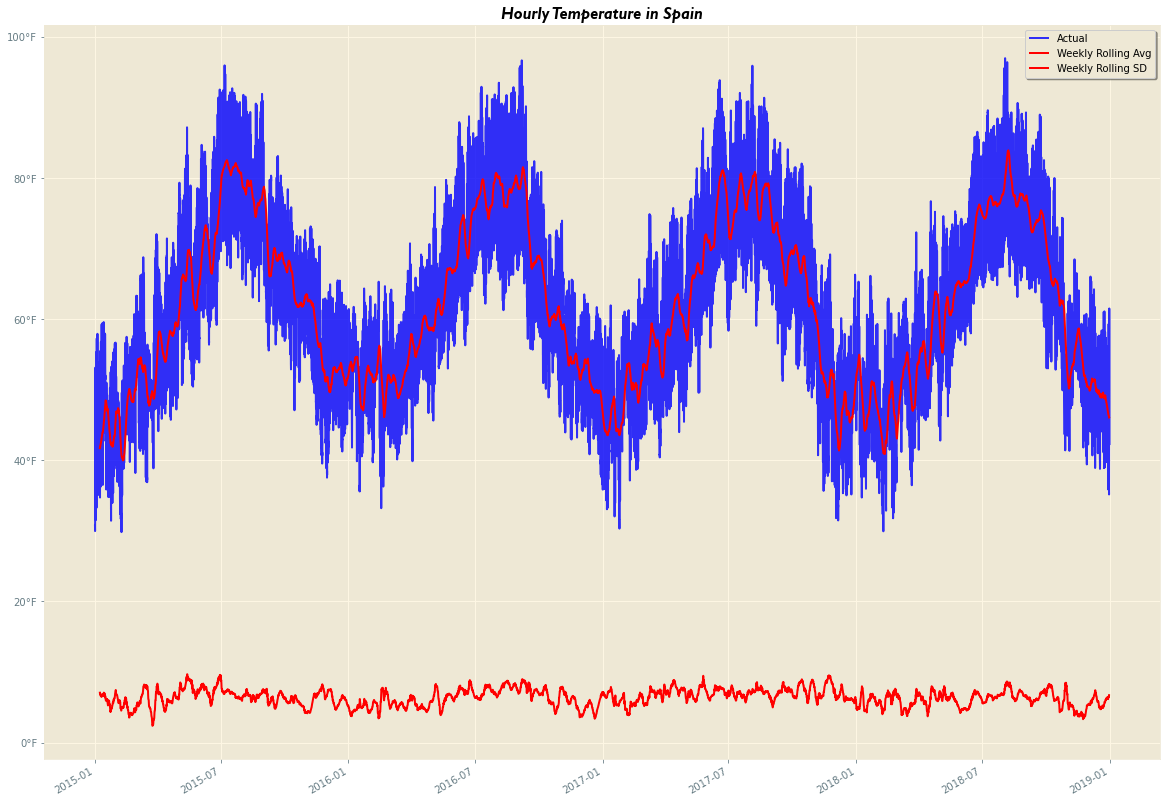

In [282]:
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Visualizations\Exploratory_Data_Analysis\Temperature'
Image(filename = path + "/Hourly_Temp.png", width=900, height=700,unconfined=True)

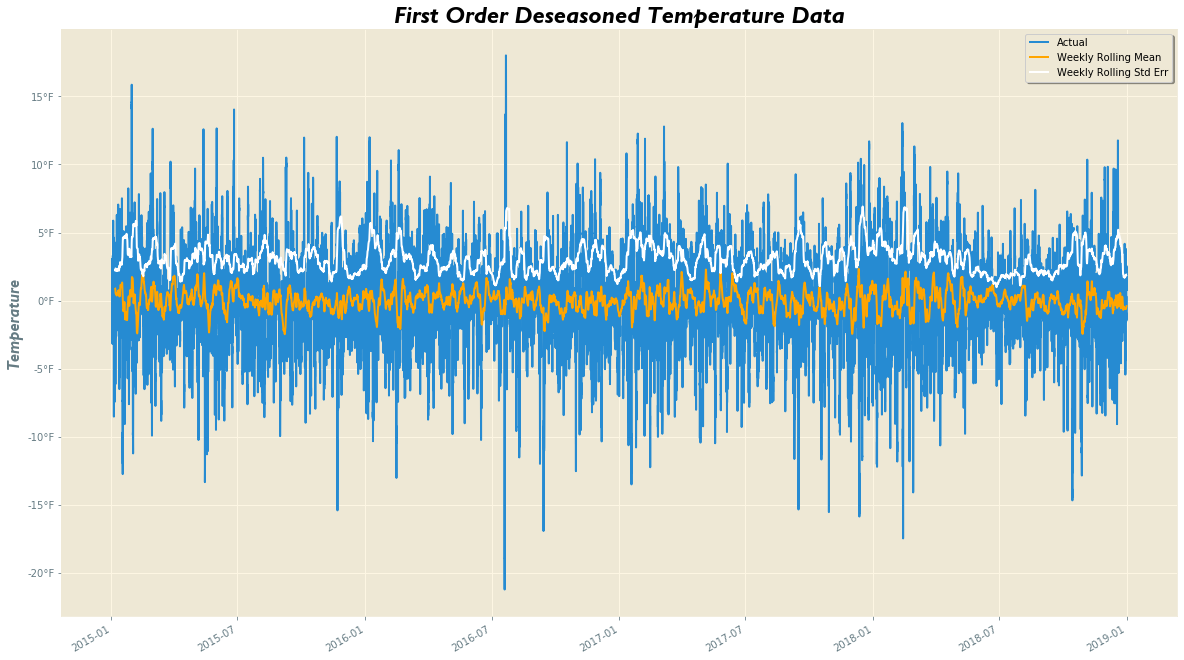

In [281]:
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Visualizations\Data_Processing\Temperature_Data'
Image(filename = path + "/Temp_Deseasoned.png", width=900, height=700,unconfined=True)

# Quick EDA of Training and Test data 

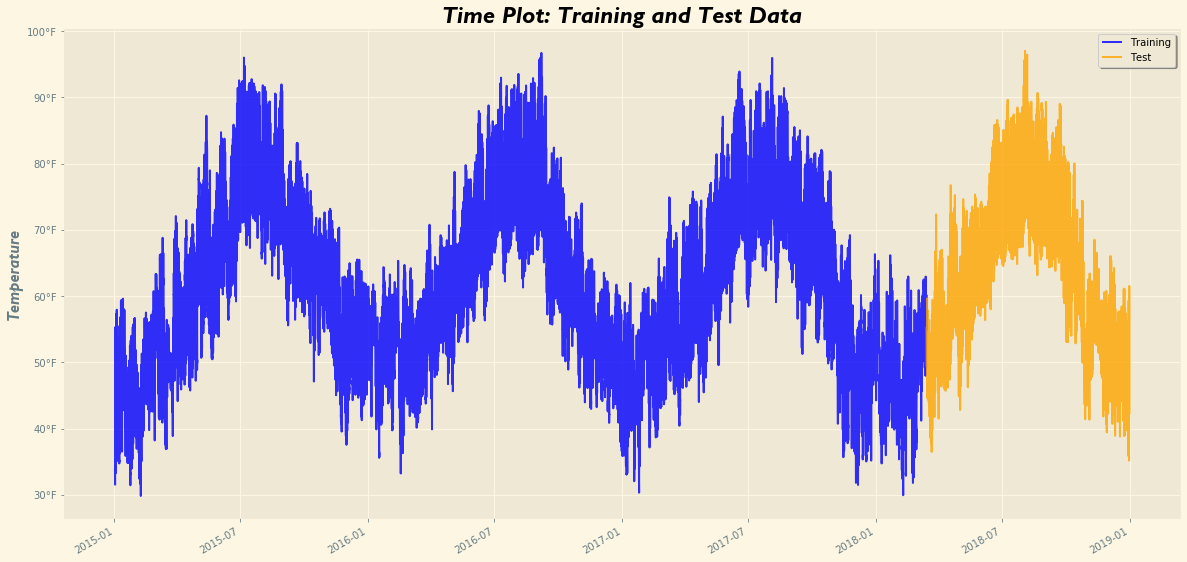

In [268]:
#Import timeseries_plot
from TimeseriesPlotter import timeseries_plot

#Set figure
f, ax = plt.subplots(figsize = (20,10))

#Plot training and test data
timeseries_plot(train.temp, color = 'blue', ax=ax, label = 'Training',alpha = .8)
timeseries_plot(test.temp, color = 'orange', ax = ax, legend = True,alpha = .8,label = 'Test', 
                title='Time Plot: Training and Test Data', title_dict=font_title,
               ylabel='Temperature', label_dict=font_label)

###Set plot aesthetics###
#Axes
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:}°F'.format(int(x))))

# Forecasting 

## Base model

**Triple Exponential Smoothing w/ Raw Temp Data**

In [269]:
#Import holt winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Fit model to training data
hw = ExponentialSmoothing(train.temp.values, seasonal='add',seasonal_periods=24 * 7 *52 ).fit()

#Store predictions
pred = hw.forecast(len(test))

**Evaluate Base model and visualize fit**

In [270]:
#Import model_performance
from TimeSeriesStats import model_performance

#View metrics of base model
results = model_performance(pred, test.temp.values)
print(results)

{'MAE': 10.945623647985984, 'MAPE': 0.1869942633698272, 'MSE': 190.40427074982577, 'RMSE': 13.79870540122608}


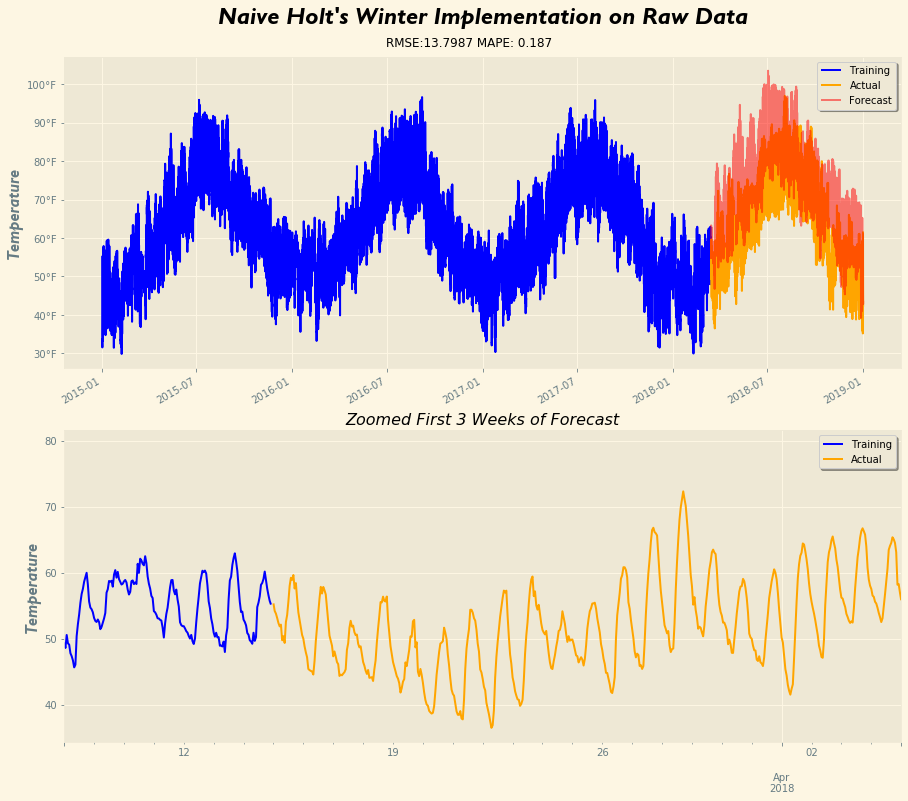

In [271]:
#Set figure
f, ax = plt.subplots(2,1, figsize = (15,14))

#Plot plot 1
timeseries_plot(train.temp, color = 'blue', ax=ax[0], label = 'Training')
timeseries_plot(test.temp, color = 'orange', ax = ax[0], legend = True,label = 'Actual', 
                ylabel = 'Temperature',label_dict=font_label)
ax[0].plot(test.index, pred, color = 'r',alpha = .5, label = 'Forecast', )


#Plot 2, zoomed in first 3 weeks
timeseries_plot(train.temp[-24*7:-1], color = 'blue', ax=ax[1], label = 'Training')
timeseries_plot(test.temp[:24*7*3], color = 'orange', ax = ax[1], legend = True,label = 'Actual', 
                ylabel = 'Temperature',label_dict=font_label)

ax[1].plot(test.index[:24*7*3], pred[:24*7*3], color = 'r', label = 'Forecast', )

###Set plot aesthetics
#Title
ax[0].set_title('Naive Holt\'s Winter Implementation on Raw Data',fontdict = font_title ,pad = 33)
f.suptitle('RMSE:{} MAPE: {}'.format(round(results['RMSE'],4), round(results['MAPE'],4)), y=.9)
ax[1].set_title('Zoomed First 3 Weeks of Forecast',style = 'italic', )




#Axes
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:}°F'.format(int(x))))

#Legend
ax[0].legend(shadow = True)

## Holt Winter with Deaseasoned Data

In [272]:
#Fit hw onto deseasoned data
hw = ExponentialSmoothing(train.temp_deseasoned1.values, seasonal = 'add', seasonal_periods=24*7*52).fit()

#Create forecast 
pred = hw.forecast(len(test))

###Transform predictions by adding back seasonality removed from differencing###

#Gather temp data from test data and predictions
hw_results = test[['temp','temp_deseasoned1']]
hw_results['temp_deseasoned1_predictions'] = pred

#Add deasoning by reversing diff(24)
hw_results['temp_predictions'] = hw_results.temp_deseasoned1_predictions + (hw_results.temp - hw_results.temp_deseasoned1)

#Adding residuals
hw_results['residuals'] = hw_results['temp_predictions'] - hw_results['temp']

#Check
display(hw_results.head(3))

,temp,temp_deseasoned1,temp_deseasoned1_predictions,temp_predictions,residuals
date_time,,,,,
2018-03-15 00:00:00,55.3424,2.4660,0.234376,53.110776,-2.231624
2018-03-15 01:00:00,54.1940,1.6704,0.360439,52.884039,-1.309961
2018-03-15 02:00:00,53.7830,1.7706,0.339615,52.352015,-1.430985


#### Evaluate Model

**Score Model**

In [273]:
#Score model predictions and print results
results = model_performance(hw_results.temp_predictions,hw_results.temp)
print(results)

{'MAE': 3.4436007730173683, 'MAPE': 0.05611127813896053, 'MSE': 18.994740387957048, 'RMSE': 4.358295582903602}


**Visualize Fit**

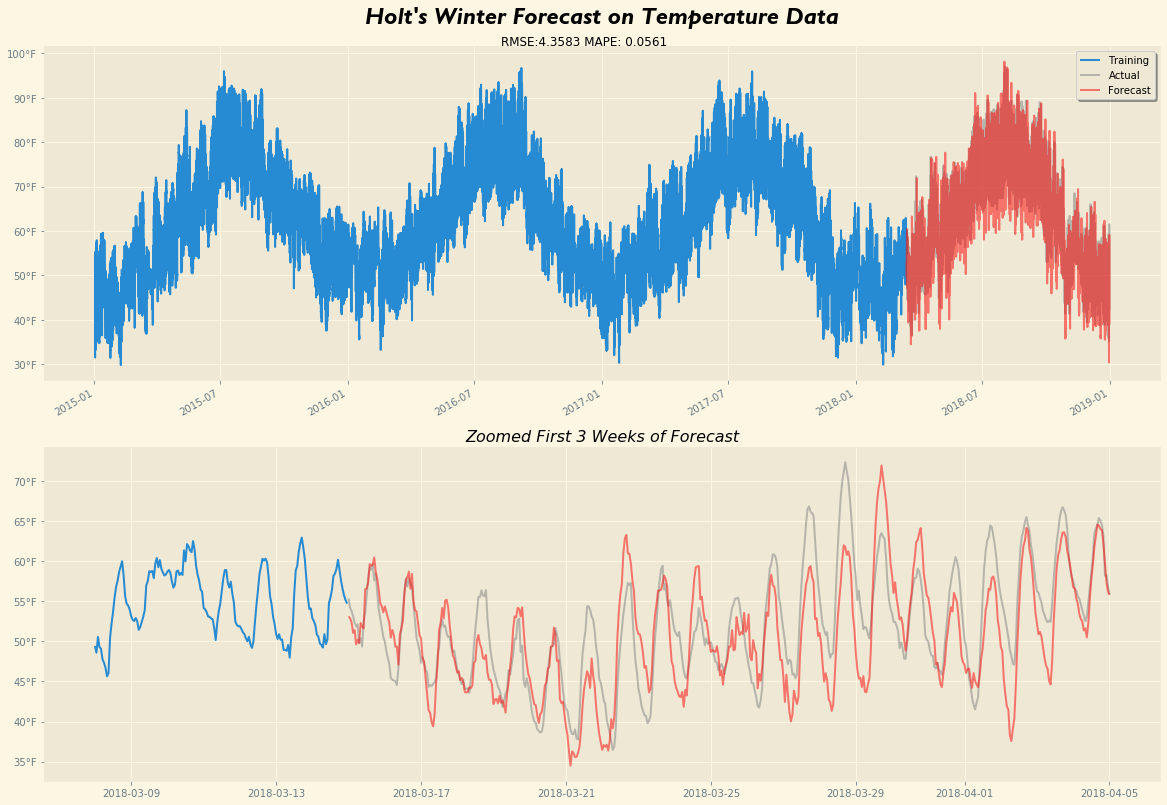

In [274]:
#Set plot
f,ax = plt.subplots(2,1,figsize = (20,15))

#Plot data
timeseries_plot(train.temp[:], ax=ax[0], label = 'Training')
timeseries_plot(hw_results.temp[:],alpha=.5,color = 'grey', ax=ax[0], label = 'Actual')
timeseries_plot(hw_results.temp_predictions[:],color = 'r', alpha=.5, ax=ax[0], label='Forecast')

#Plot Zoomed data for first 3 weeks for forecats
ax[1].plot(train.index[-24*7*1:], train.temp[-24*7*1:])
ax[1].plot(hw_results.index[:24*7*3], hw_results.temp[:24*7*3],color = 'grey', alpha=.5)
ax[1].plot(hw_results.index[:24*7*3], hw_results.temp_predictions[:24*7*3],color = 'r', alpha=.5)

###Set plot aesthetics###
#Title
ax[0].set_title('Holt\'s Winter Forecast on Temperature Data',fontdict = font_title, pad = 23)
f.suptitle('RMSE:{} MAPE: {}'.format(round(results['RMSE'],4), round(results['MAPE'],4)), y=.89, fontsize = 12)

ax[1].set_title('Zoomed First 3 Weeks of Forecast',style = 'italic', )

#Axes
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:}°F'.format(int(x))))
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:}°F'.format(int(x))))

#Legend
ax[0].legend(shadow = True)

## ARMA

**View ACF and PACF to select parameters for order**

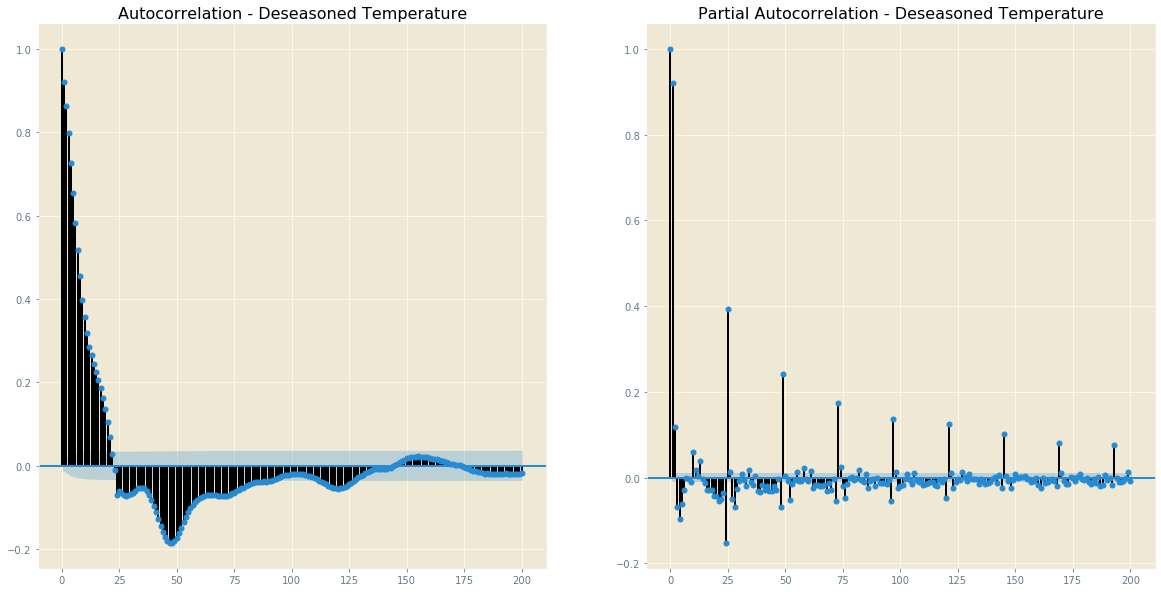

In [275]:
#
Image(filename = path + "/ACF_PACF_Temp_Deseasoned.png", width=900, height=700,unconfined=True)


**Create ARMA Model**

In [276]:
#Import ARMA model
from statsmodels.tsa.arima_model import ARMA

#Fit model to deseasoned temp data
arma = ARMA(train.temp_deseasoned1.values[24:], order = (5,0)).fit()

#Print summary
print(arma.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                28014
Model:                     ARMA(5, 0)   Log Likelihood              -47256.534
Method:                       css-mle   S.D. of innovations              1.307
Date:                Sun, 17 May 2020   AIC                          94527.068
Time:                        14:10:24   BIC                          94584.751
Sample:                             0   HQIC                         94545.637
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0128      0.089      0.143      0.886      -0.162       0.188
ar.L1.y        0.7856      0.006    131.788      0.000       0.774       0.797
ar.L2.y        0.2097      0.008     27.655      0.0

**Inspect residuals**

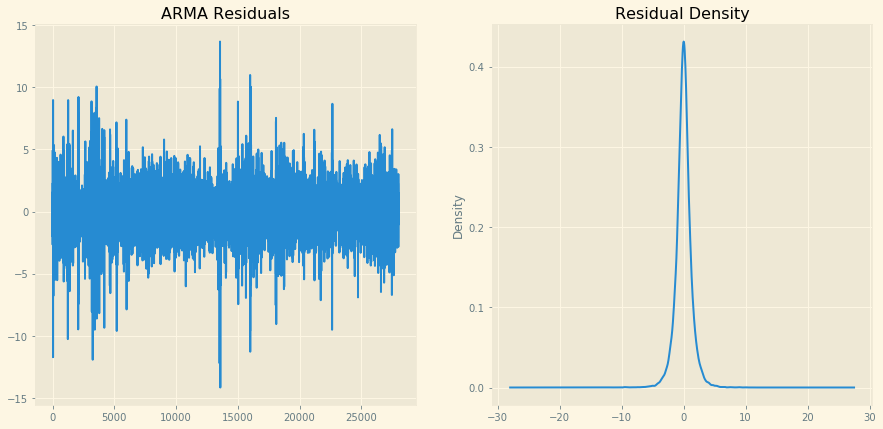

In [277]:
#Extract residuals from arma model and store in df
residuals = pd.DataFrame(arma.resid)

#Set plot
fig, ax = plt.subplots(1,2, figsize = (15,7))

#Plot residuals and density
residuals.plot(title="ARMA Residuals", ax=ax[0], legend = False)
residuals.plot(kind='kde', title='Residual Density', ax=ax[1], legend = False)

**Forecast with ARMA Model**

In [278]:
#Create Forecast
forecast,err, conf = arma.forecast(len(test))

#Create empty df
arma_results = pd.DataFrame(index=test.index)

#Store forecast, err, and conf into df
arma_results['forecast']= pd.Series(forecast, index=test.index)
arma_results['error'] = err
arma_results['lower_conf'] = conf[:,0]
arma_results['upper_conf'] = conf[:,1]

#Reverse differencing on forecast, lower and upper conf
arma_results['forecast'] = arma_results['forecast'] + (test.temp - test.temp_deseasoned1)
arma_results['lower_conf'] =arma_results['lower_conf'] + (test.temp - test.temp_deseasoned1)
arma_results['upper_conf'] =arma_results['upper_conf'] + (test.temp - test.temp_deseasoned1)

#Check
arma_results.head()

,forecast,error,lower_conf,upper_conf
date_time,,,,
2018-03-15 00:00:00,53.831978,1.307238,51.269840,56.394117
2018-03-15 01:00:00,53.514347,1.662391,50.256120,56.772574
2018-03-15 02:00:00,52.946979,1.982905,49.060557,56.833401
2018-03-15 03:00:00,51.714526,2.269530,47.266329,56.162722
2018-03-15 04:00:00,51.401104,2.506835,46.487797,56.314411


** View Metrics**

In [279]:
#EValuate model performance on test data
results = model_performance(arma_results['forecast'], test['temp'])
results

{'MAE': 2.184208443202168,
 'MAPE': 0.03665525119054408,
 'MSE': 8.566205049720923,
 'RMSE': 2.9268079967297007}

**Visualize Forecast**

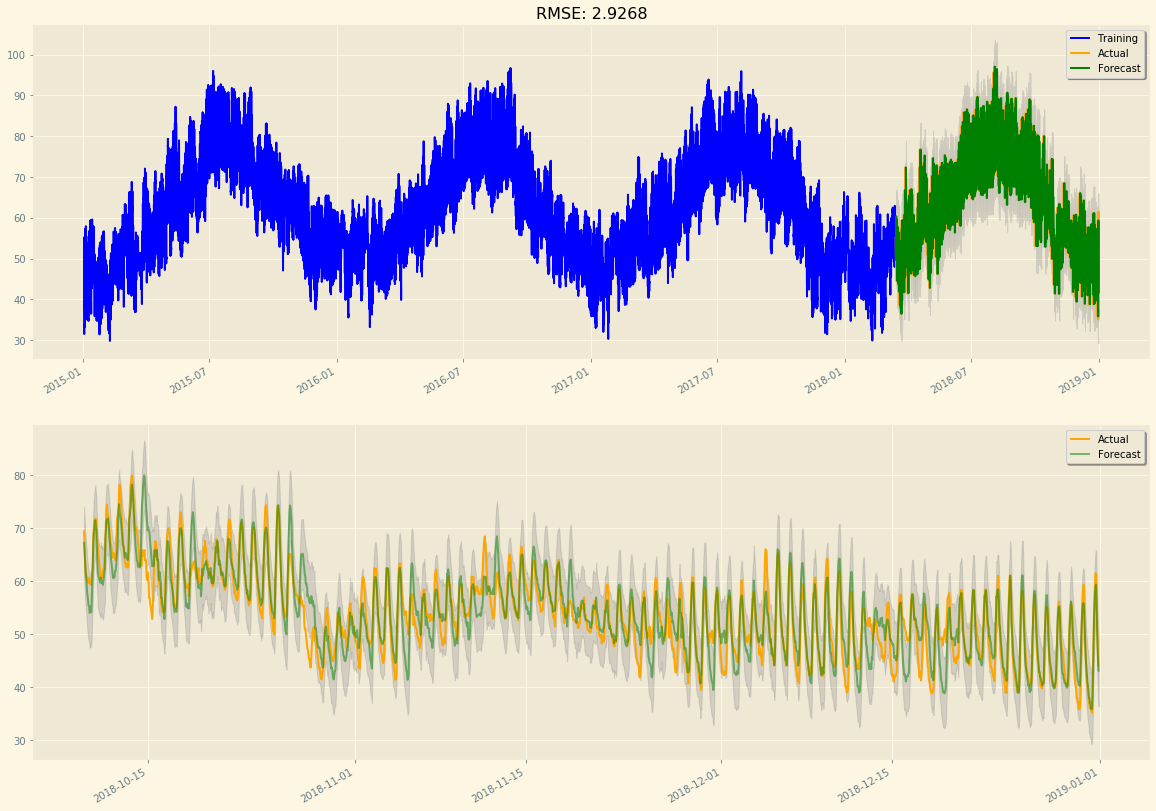

In [280]:
#Set PLot
fig, ax = plt.subplots(2,1, figsize = (20,15))

#Plot data with forecast
timeseries_plot(train.temp, color = 'b', ax=ax[0], label = 'Training')
timeseries_plot(test.temp, color = 'orange', ax = ax[0], label = 'Actual')
timeseries_plot(arma_results.forecast, color = 'g', 
                title='RMSE: {}'.format(round(results['RMSE'],4)),ax = ax[0],legend=True, label = 'Forecast')

timeseries_plot(test.temp[-2000:-1], color = 'orange', ax = ax[1], label = 'Actual')
timeseries_plot(arma_results.forecast[-2000:-1], color = 'g', alpha = .5,
                title='',ax = ax[1],legend=True, label = 'Forecast')

#Add confidence intervals
ax[0].fill_between(test.index, arma_results.lower_conf, arma_results.upper_conf, color = 'gray', alpha=.25)

ax[1].fill_between(test.index[-2000:-1], arma_results.lower_conf[-2000:-1], arma_results.upper_conf[-2000:-1], color = 'gray', alpha=.25)

#possible idea

Scrape temperature data for 2019 through june and see how well this model performs when retrained on all data